In [1]:
from amuse.units import units
from amuse.lab import Huayno, nbody_system, new_galactics_model
from amuse.lab import Gadget2
from amuse.community.ph4.interface import ph4
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from amuse.couple import bridge
from amuse.community.hermite.interface import Hermite
from amuse.community.bhtree.interface import BHTree

In [2]:
%%time

# Milky Way := Mdisk = 4.5 Mbulge | Mhalo = 100 Mbulge
# Andromeda := Mdisk = 4-7 Mbulge | Mhalo = 87 Mbulge
# Mdisk = 5 Mbulge, Mhalo = 95 Mbulge

n_halo  = 4750.0
n_bulge = 50.0
n_disk  = 250.0
M_galaxy = 1e12 | units.MSun
R_galaxy = 80  | units.kpc
converter = nbody_system.nbody_to_si(M_galaxy, R_galaxy)

galaxy1 = new_galactics_model(n_halo,
                                converter,
                                do_scale=True,
                                bulge_number_of_particles=n_bulge,
                                disk_number_of_particles=n_disk)
# Order of particles: Disk => Bulge => Halo

CPU times: user 2.33 s, sys: 1.49 s, total: 3.82 s
Wall time: 6.01 s


In [3]:
%%time
M_galaxy_2 = 5e11 | units.MSun
R_galaxy_2 = 50  | units.kpc
converter_2 = nbody_system.nbody_to_si(M_galaxy_2, R_galaxy_2)
galaxy2 = new_galactics_model(n_halo,
                                converter_2,
                                do_scale=True,
                                bulge_number_of_particles=n_bulge,
                                disk_number_of_particles=n_disk)

CPU times: user 2.41 s, sys: 1.55 s, total: 3.96 s
Wall time: 4.05 s


In [4]:
%%time
galaxy1.rotate(0., np.pi/2, 0.)
galaxy2.x  += 400 | units.kpc
galaxy2.vx += -100 |units.kms
galaxy2.vy += +10 |units.kms

CPU times: user 2.19 ms, sys: 0 ns, total: 2.19 ms
Wall time: 2.45 ms


In [5]:
converter = nbody_system.nbody_to_si(1.e12|units.MSun, 100|units.kpc)
dynamics = BHTree(converter) # ph4 Does the trick, but is kinda slow
dynamics.parameters.epsilon_squared = (100|units.parsec)**2
set1 = dynamics.particles.add_particles(galaxy1)
set2 = dynamics.particles.add_particles(galaxy2)

In [6]:
%%time
n_halo_test  = 1000
n_disk_test  = 1000
n_bulge_test = 1000

test_particles_1 = new_galactics_model(n_halo_test,
                                converter,
                                do_scale=True,
                                bulge_number_of_particles=n_bulge_test,
                                disk_number_of_particles=n_disk_test)

test_particles_2 = new_galactics_model(n_halo_test,
                                converter_2,
                                do_scale=True,
                                bulge_number_of_particles=n_bulge_test,
                                disk_number_of_particles=n_disk_test)

CPU times: user 3.48 s, sys: 2.75 s, total: 6.23 s
Wall time: 7.02 s


In [7]:
#set the mass of the test particles to 0
test_particles_1.mass = 0 |units.kg
test_particles_2.mass = 0 |units.kg

#we're only interested in the particles from the stars, and not the halo.
test_particles_1_stars = test_particles_1[:int(n_bulge_test+n_disk_test)]
test_particles_2_stars = test_particles_2[:int(n_bulge_test+n_disk_test)]

#rotate and translate in the same way as the galaxies
test_particles_1_stars.rotate(0., np.pi/2, 0.)
test_particles_2_stars.x  += 400 | units.kpc
test_particles_2_stars.vx += -100 |units.kms
test_particles_2_stars.vy += +10 |units.kms

star_dynamics = BHTree(converter)
star_set_1 = star_dynamics.particles.add_particles(test_particles_1_stars)
star_set_2 = star_dynamics.particles.add_particles(test_particles_2_stars)

In [8]:
gravity = bridge.Bridge(use_threading=False)
gravity.add_system(star_dynamics, (dynamics,) )
gravity.add_system(dynamics)
#gravity.add_system(star_dynamics, (galaxy2,) )
#gravity.add_system(galaxy2, (galaxy1,) )
#gravity.add_system(galaxy1, (galaxy2,) )
channel = star_dynamics.particles.new_channel_to(star_dynamics.particles)

In [9]:
gravity.timestep = 10|units.Myr
threshold = 20. |units.Myr 

times = np.arange(0., 5000, 10) | units.Myr
for time in tqdm(range(len(times))):
    gravity.evolve_model(times[time])
    if times[time] %threshold == 0|units.Myr:
        channel.copy()
        plt.figure(figsize = (10,8))
        plt.scatter(set1.x[:int(n_bulge+n_disk)].value_in(units.kpc), set1.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=0.3,label = 'Big galaxy')
        plt.scatter(set2.x[:int(n_bulge+n_disk)].value_in(units.kpc), set2.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=0.3,label = 'Small galaxy')
        plt.title("Disk + Bulge \n time = " +str(times[time]) )
        #plt.text(-100,80,"time = " + str(times[time])+ "Myr")
        plt.legend()
        plt.xlabel("x [kpc]")
        plt.ylabel("y [kpc]")
        plt.xlim(-200,500)
        plt.axis("equal")
        #plt.ylim(-100,100)
        plt.savefig('./merge_plots/snap%04d.png'%time)
        #plt.show()
        plt.close()
#gravity.stop()

100%|██████████| 500/500 [17:56<00:00,  2.15s/it]


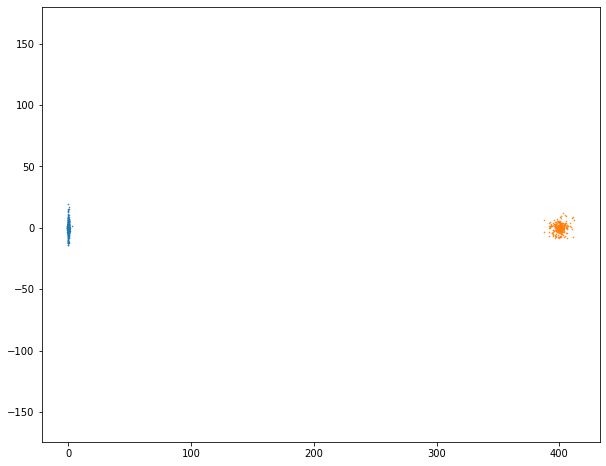

'\nplt.figure(figsize=[10,8])\nplt.scatter(galaxy1.x[int(n_bulge+n_disk):].value_in(units.kpc), galaxy1.y[int(n_bulge+n_disk):].value_in(units.kpc), s=0.3)\nplt.scatter(galaxy2.x[int(n_bulge+n_disk):].value_in(units.kpc), galaxy2.y[int(n_bulge+n_disk):].value_in(units.kpc), s=0.3)\nplt.axis("equal")\nplt.show()'

In [10]:
plt.figure(figsize=[10,8])
plt.scatter(galaxy1.x[:int(n_bulge+n_disk)].value_in(units.kpc), galaxy1.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=0.3)
plt.scatter(galaxy2.x[:int(n_bulge+n_disk)].value_in(units.kpc), galaxy2.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=0.3)
plt.axis("equal")
plt.show()

"""
plt.figure(figsize=[10,8])
plt.scatter(galaxy1.x[int(n_bulge+n_disk):].value_in(units.kpc), galaxy1.y[int(n_bulge+n_disk):].value_in(units.kpc), s=0.3)
plt.scatter(galaxy2.x[int(n_bulge+n_disk):].value_in(units.kpc), galaxy2.y[int(n_bulge+n_disk):].value_in(units.kpc), s=0.3)
plt.axis("equal")
plt.show()"""

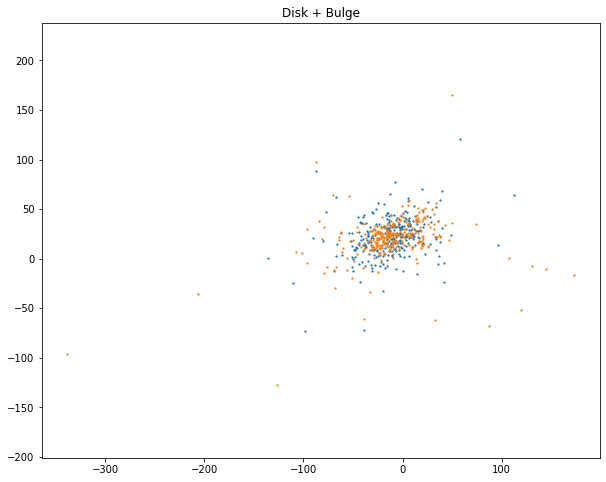

'\nplt.figure(figsize=[10,8])\nplt.scatter(set1.x[int(n_bulge+n_disk):].value_in(units.kpc), set1.y[int(n_bulge+n_disk):].value_in(units.kpc), s=1.5)\nplt.scatter(set2.x[int(n_bulge+n_disk):].value_in(units.kpc), set2.y[int(n_bulge+n_disk):].value_in(units.kpc), s=1.5)\nplt.title("Halo")\nplt.axis("equal")\nplt.show()'

In [11]:
plt.figure(figsize=[10,8])
plt.scatter(set1.x[:int(n_bulge+n_disk)].value_in(units.kpc), set1.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=1.5)
plt.scatter(set2.x[:int(n_bulge+n_disk)].value_in(units.kpc), set2.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=1.5)
plt.title("Disk + Bulge")
plt.axis("equal")
plt.show()

"""
plt.figure(figsize=[10,8])
plt.scatter(set1.x[int(n_bulge+n_disk):].value_in(units.kpc), set1.y[int(n_bulge+n_disk):].value_in(units.kpc), s=1.5)
plt.scatter(set2.x[int(n_bulge+n_disk):].value_in(units.kpc), set2.y[int(n_bulge+n_disk):].value_in(units.kpc), s=1.5)
plt.title("Halo")
plt.axis("equal")
plt.show()"""

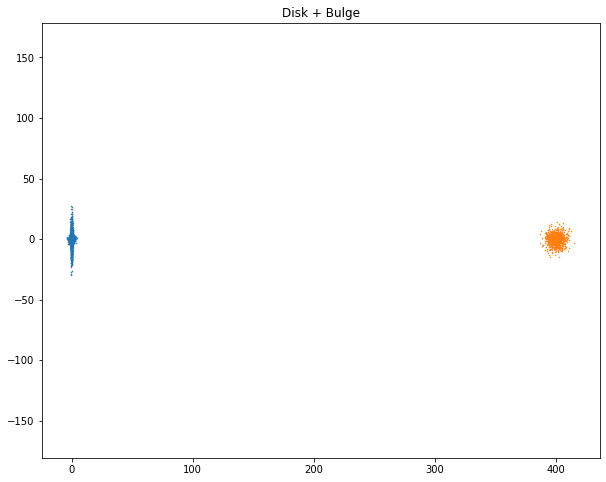

In [12]:
plt.figure(figsize=[10,8])
plt.scatter(test_particles_1_stars.x[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), test_particles_1_stars.y[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), s=0.3)
plt.scatter(test_particles_2_stars.x[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), test_particles_2_stars.y[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), s=0.3)
plt.title("Disk + Bulge")
plt.axis("equal")
plt.show()

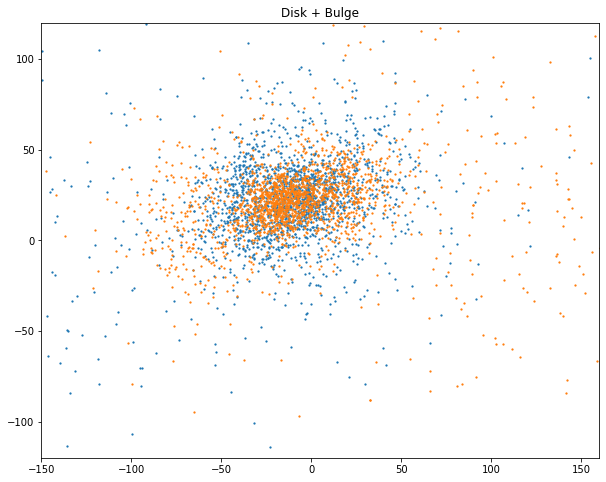

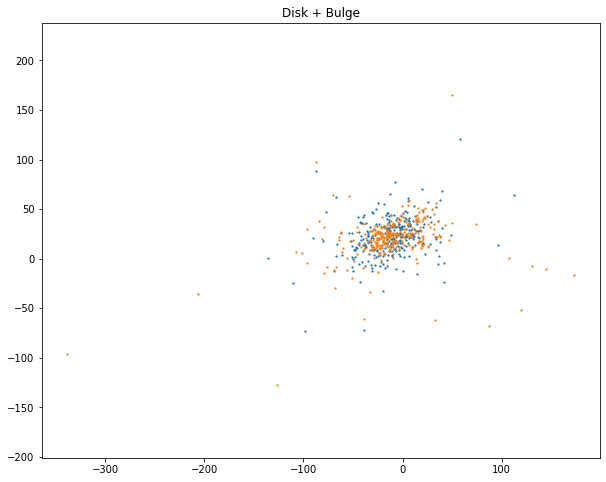

In [13]:
plt.figure(figsize=[10,8])
plt.scatter(star_set_1.x[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), star_set_1.y[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), s=1.5)
plt.scatter(star_set_2.x[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), star_set_2.y[:int(n_bulge_test+n_disk_test)].value_in(units.kpc), s=1.5)
plt.title("Disk + Bulge")
#plt.axis("equal")
plt.ylim(-120, 120)
plt.xlim(-150, 160)
plt.show()

plt.figure(figsize=[10,8])
plt.scatter(set1.x[:int(n_bulge+n_disk)].value_in(units.kpc), set1.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=1.5)
plt.scatter(set2.x[:int(n_bulge+n_disk)].value_in(units.kpc), set2.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=1.5)
plt.title("Disk + Bulge")
plt.axis("equal")
plt.show()

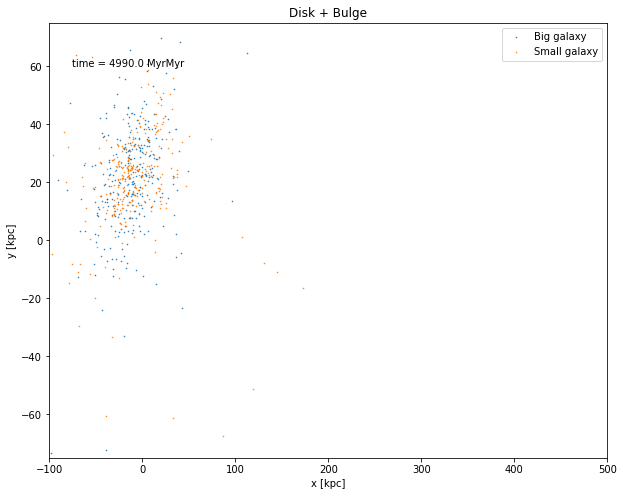

In [14]:
plt.figure(figsize = (10,8))
plt.scatter(set1.x[:int(n_bulge+n_disk)].value_in(units.kpc), set1.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=0.3,label = 'Big galaxy')
plt.scatter(set2.x[:int(n_bulge+n_disk)].value_in(units.kpc), set2.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=0.3,label = 'Small galaxy')
plt.text(-75,60,"time = " + str(times[time])+ "Myr")
plt.title("Disk + Bulge")
#plt.axis("equal") 
plt.legend()
plt.xlabel("x [kpc]")
plt.ylabel("y [kpc]")
plt.xlim(-100,500)
plt.ylim(-75,75)
plt.show()